# ARIMA Model for UNH Stock Price Prediction

In [2]:
# Import required libraries
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from IPython.core.debugger import set_trace
import os
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates

In [3]:
# Define the function to fetch and process stock data
def getdata(tickers):
    data = []
    end_date = datetime.today()
    start_date = end_date - timedelta(days=5*365)  # Approximate 5 years
    for ticker in tickers:
        stock_data = yf.download(ticker, start=start_date, end=end_date).reset_index()
        stock_data['Ticker'] = ticker
        data.append(stock_data)
    # Concatenate all the individual DataFrames into a single DataFrame
    return pd.concat(data, ignore_index=True)

# Get data for the specified ticker(s)
df = getdata(['UNH'])

# Save the DataFrame to a CSV file
csv_file_path = 'UNH_data.csv'
df.to_csv(csv_file_path, index=False)

# Read the CSV file back into a DataFrame
df = pd.read_csv(csv_file_path)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df = pd.read_csv('UNH_data.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2019-05-23,247.979996,248.149994,244.389999,246.500000,228.723282,3934600,UNH
1,2019-05-24,247.250000,249.360001,245.509995,247.630005,229.771790,2973900,UNH
2,2019-05-28,248.500000,249.300003,241.979996,242.059998,224.603485,6172700,UNH
3,2019-05-29,239.850006,243.029999,237.899994,242.399994,224.918991,3958400,UNH
4,2019-05-30,241.919998,245.350006,241.339996,243.500000,225.939606,2646600,UNH


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
1253,2024-05-15,514.830017,522.590027,514.830017,517.549988,517.549988,2981200,UNH
1254,2024-05-16,520.000000,528.159973,519.510010,521.270020,521.270020,3655800,UNH
1255,2024-05-17,522.940002,525.849976,520.010010,524.630005,524.630005,2657200,UNH
1256,2024-05-20,524.630005,524.630005,516.539978,517.229980,517.229980,2476200,UNH
1257,2024-05-21,518.320007,524.719971,515.919983,523.549988,523.549988,2521900,UNH


In [7]:
df['Close'].describe()

count    1258.000000
mean      412.111145
std       102.900817
min       194.860001
25%       308.004997
50%       450.479996
75%       501.892487
max       555.150024
Name: Close, dtype: float64

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term
- d is the number of differencing required to make the time series stationary
- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeleled with ARIMA models.

### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times.

And the minimum number of differencing operations needed to make the series stationary needs to be imputd into our ARIMA model.

### ADF test

We'll use the Augmented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis $H_0$ is that the time series is non-stationary. So, if the p-value of the test is less than $\alpha = 0.05$, then we can reject the $H_0$ and conclude that the time series is indeed stationary.


In [9]:
# checking if the series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'P-value: {result[1]}')

ADF Statistic: -1.3101584810120823
P-value: 0.6245120762202956


So, in our case, we need to find the order of differencing.

### Autocorrelation Function (ACF)

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

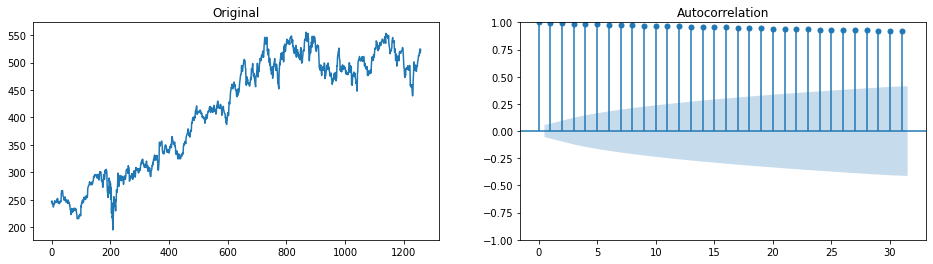

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
plot_acf(df.Close, ax=ax2);

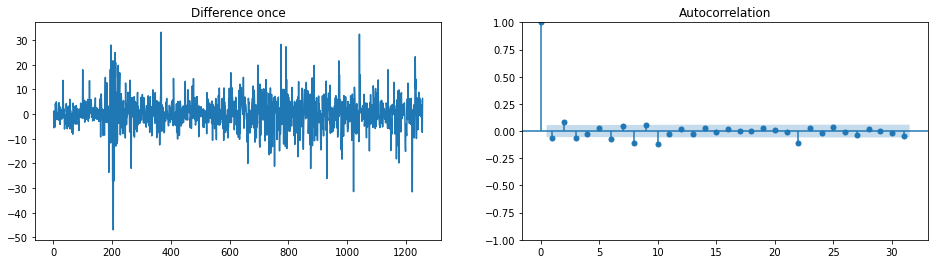

In [12]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

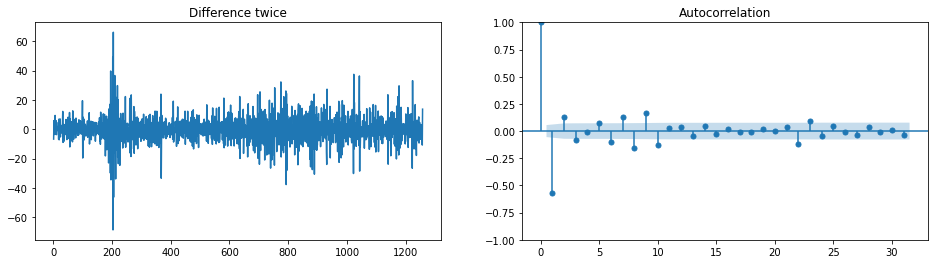

In [13]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);

In [15]:
from pmdarima.arima.utils import ndiffs

In [16]:
ndiffs(df.Close, test="adf")

1

We can set d = 1.

### p

p is the order of the Auto-Regressive (AR) term. It refers to the number of lags to be used as predictors.

We can find the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

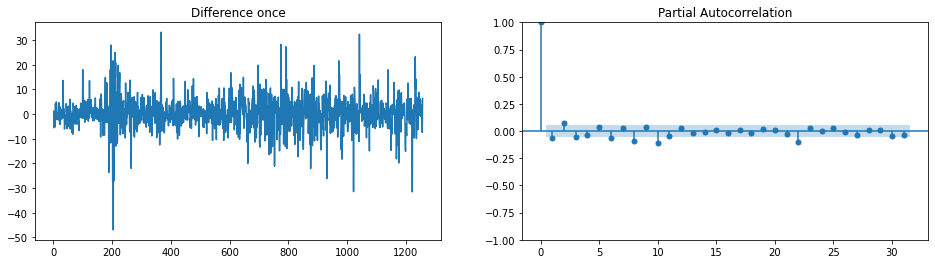

In [19]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag 2 is significant as it's above the significance line, so we set p = 2.

### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

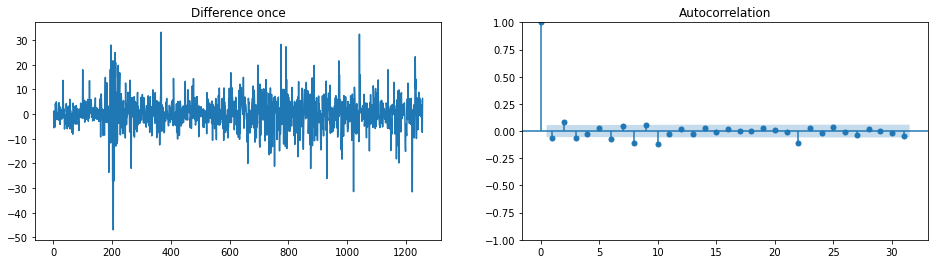

In [20]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

2 is a suitable term for q.

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model
model = ARIMA(df.Close, order=(2, 1, 2))
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1258
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4148.778
Date:                Tue, 21 May 2024   AIC                           8307.557
Time:                        17:53:10   BIC                           8333.239
Sample:                             0   HQIC                          8317.209
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7235      0.038    -45.543      0.000      -1.798      -1.649
ar.L2         -0.9058      0.036    -25.117      0.000      -0.976      -0.835
ma.L1          1.6532      0.046     36.047      0.000       1.563       1.743
ma.L2          0.8442      0.045     18.959      0.000       0.757       0.931
sigma2        43.0813      0.984     43.763      0.000      41.152      45.011
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):              1053.79
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.18
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

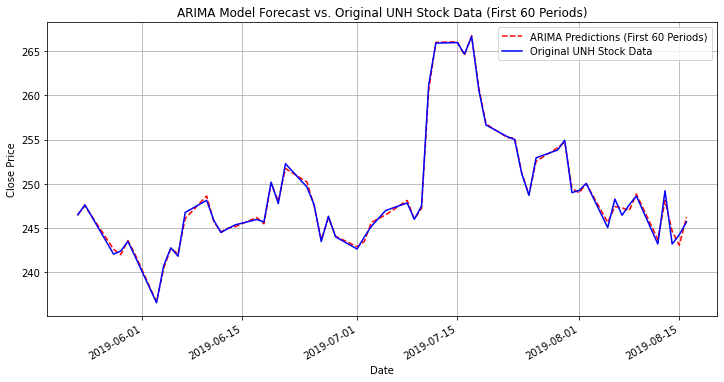

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Predict the first 60 periods using ARIMA model
predictions = result.predict(start=1, end=60, dynamic=False)

# Plotting
plt.figure(figsize=(12, 6))

# Plot predicted values for the first 60 periods from ARIMA model vs original data
plt.plot(df['Date'][:60], predictions, color='red', linestyle='--', label='ARIMA Predictions (First 60 Periods)')
plt.plot(df['Date'][:60], df['Close'][:60], color='blue', label='Original UNH Stock Data')

# Formatting the x-axis to show date labels clearly
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the date labels

# Add grid
plt.grid(True)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model Forecast vs. Original UNH Stock Data (First 60 Periods)')
plt.legend()
plt.show()


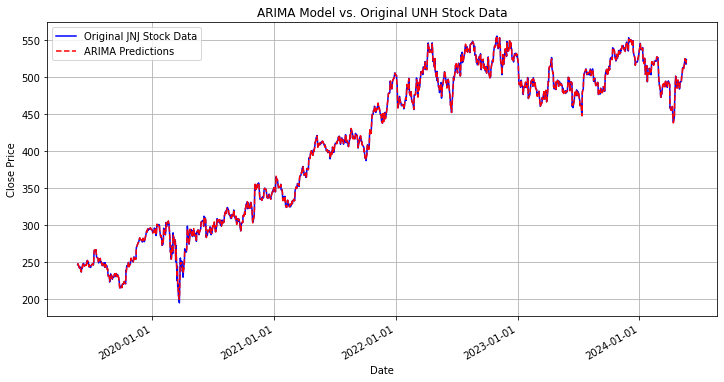

In [36]:
plt.figure(figsize=(12, 6))

# Plot original UNH stock data
plt.plot(df['Date'], df['Close'], color='blue', label='Original JNJ Stock Data')
# Plot predicted values from ARIMA model
plt.plot(df['Date'], result.predict(start=1, end=len(df)), color='red', linestyle='--', label='ARIMA Predictions')

# Formatting the x-axis to show date labels clearly
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the date labels

plt.grid(True)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model vs. Original UNH Stock Data')
plt.legend()
plt.savefig('timeseries.jpg')
plt.show()

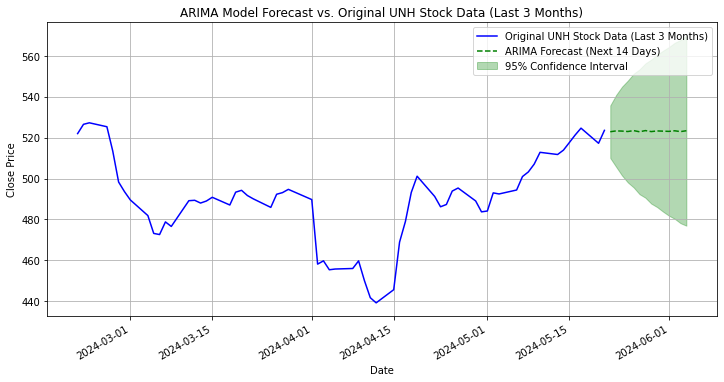

           Date  Forecasted Close Price  Lower CI (95%)  Upper CI (95%)
1258 2024-05-22              522.877482      510.013001      535.741962
1259 2024-05-23              523.287144      505.721939      540.852349
1260 2024-05-24              523.190222      501.499404      544.881041
1261 2024-05-25              522.986207      498.087606      547.884807
1262 2024-05-26              523.425621      495.612449      551.238793
1263 2024-05-27              522.853074      492.337088      553.369060
1264 2024-05-28              523.441859      490.605521      556.278197
1265 2024-05-29              522.945676      487.730865      558.160486
1266 2024-05-30              523.267551      486.037542      560.497559
1267 2024-05-31              523.162224      483.843885      562.480563
1268 2024-06-01              523.052210      481.867892      564.236529
1269 2024-06-02              523.337223      480.322144      566.352302
1270 2024-06-03              522.945645      478.153465      567

In [37]:
# Forecast the next 14 days
forecast = result.get_forecast(steps=14)
forecast_dates = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=14)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plotting
plt.figure(figsize=(12, 6))

# Filter the data for the last 3 months
three_months_ago = df['Date'].iloc[-1] - timedelta(days=90)
df_last_3_months = df[df['Date'] >= three_months_ago]
# Plot original UNH stock data (last 3 months)
plt.plot(df_last_3_months['Date'], df_last_3_months['Close'], color='blue', label='Original UNH Stock Data (Last 3 Months)')

# Plot forecasted values for the next 14 days
plt.plot(forecast_dates, forecast_values, color='green', linestyle='--', label='ARIMA Forecast (Next 14 Days)')

# Plot the confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.3, label='95% Confidence Interval')

# Formatting the x-axis to show date labels clearly
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the date labels

# Add grid
plt.grid(True)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model Forecast vs. Original UNH Stock Data (Last 3 Months)')
plt.legend()
plt.savefig('ts_fc.jpg')
plt.show()

# Print the forecasted prices and confidence intervals
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Close Price': forecast_values,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1]
})
print(forecast_df)